In [1]:
%%javascript
utils.load_extension("collapsible_headings/main")
utils.load_extension("autosavetime/main")
utils.load_extension("execute_time/ExecuteTime")

<IPython.core.display.Javascript object>

In [37]:
import pandas as pd
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from cern_utils import plot_feature_importance
from sklearn.metrics import roc_auc_score,auc
from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
plt.style.use('seaborn')

import math

import random 
random.seed(0)
from path_utils import return_impurity,pie_plot_filtered

In [3]:
train = pd.read_csv("train.csv", index_col="Id")
test = pd.read_csv("test.csv", index_col="Id")
train = train.drop(columns="BUTTER")
test = test.drop(columns="BUTTER")

## Feature Engineering

In [4]:
train['train']=1
test['train']=0


In [5]:
df = train.append(test)

In [6]:
df.columns = df.columns.str.replace(' ', '')

In [7]:
df.head()

,B_OWNPV_CHI2,B_IPCHI2_OWNPV,B_FDCHI2_OWNPV,B_DIRA_OWNPV,B_PT,Kst_892_0_IP_OWNPV,Kst_892_0_cosThetaH,Kplus_IP_OWNPV,Kplus_P,piminus_IP_OWNPV,piminus_P,gamma_PT,piminus_ETA,Kplus_ETA,signal,train
Id,,,,,,,,,,,,,,,,
0,28.878847,2.662533,2924.690991,0.999997,19085.568945,0.569198,-0.575502,0.581565,66850.893711,0.637969,14298.486178,7940.694301,2.628526,2.680116,1.0,1
1,34.233566,0.092746,346.948714,0.999997,6631.244546,0.248707,-0.615941,0.277898,39274.475071,0.148815,11553.163934,3904.681337,3.292504,3.085754,1.0,1
2,36.113632,2.442423,238.553023,0.999986,7740.918989,0.222347,0.249383,0.216576,27757.153899,0.249840,24081.196003,4738.891687,3.433676,3.121906,1.0,1
3,14.286133,6.337556,227.375132,0.999806,6740.281614,0.347316,0.591884,0.306927,10593.207077,0.400748,11343.521945,3308.943750,2.291867,2.200712,0.0,1
4,60.474274,7.632751,106.730650,0.999905,5556.388794,0.204273,0.655850,0.196600,11801.249543,0.223101,25940.693317,4026.326871,3.290073,3.281829,0.0,1


## Splits

In [8]:
train = df[df['train']==1].drop(columns='train')
test = df[df['train']==0].drop(columns='train')

In [9]:
X_tr, X_te, y_tr, y_te = train_test_split(
    train.drop(columns="signal"),
    train.signal,
    stratify=train.signal,
    random_state=0,  # train_size=0.99
)

## DT

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dt = DecisionTreeClassifier()

In [13]:
dt.fit(X_tr,y_tr)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [36]:
return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)]).head(5)

,feature,impurity,samples,imp_child,samples_child,impurity_gain,samples_gain
0,Kst_892_0_cosThetaH,0.444889,159496.0,0.480466,121606.0,7.856306,0.237561
1,Kst_892_0_IP_OWNPV,0.480466,121606.0,0.416789,63589.0,20.015783,0.363752
2,B_IPCHI2_OWNPV,0.416789,63589.0,0.295297,26922.0,11.632409,0.229893
3,B_PT,0.295297,26922.0,0.232056,18921.0,2.231563,0.050164
4,Kst_892_0_IP_OWNPV,0.232056,18921.0,0.309266,7260.0,1.345149,0.073112


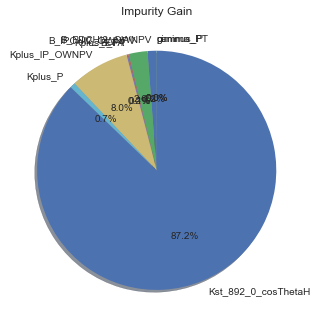

In [88]:
res_g = (
    return_impurity(dt, X_tr[X_tr.index == random.choice(X_tr.index)])
    .groupby("feature", as_index=False)
    .sum()
)

pie_plot_filtered(res_g, "samples_gain", title="Impurity Gain")